### **Load necessary libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# to show the folders under the dataset
!ls "/content/drive/My Drive/Images/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
test_label_01  test_label_02  train_label_01  train_label_02


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras
import tensorflow as tf
import os
import pandas as pd
import math
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from keras.datasets import cifar10
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.losses import categorical_crossentropy

tf.config.list_physical_devices('GPU')

from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from PIL import Image
from keras.models import load_model

### **Load the dataset**

In [3]:
# Set the paths to the folders containing the image files
train_not_landfill_path = '/content/drive/MyDrive/Images/train_label_02'
train_landfill_path = '/content/drive/MyDrive/Images/train_label_01'
test_not_landfill_path = '/content/drive/MyDrive/Images/test_label_02'
test_landfill_path = '/content/drive/MyDrive/Images/test_label_01'


# get a list of all files in the folder
train_not_landfill_path_file_list = os.listdir(train_not_landfill_path)
train_landfill_path_file_list = os.listdir(train_landfill_path)
test_not_landfill_path_file_list = os.listdir(test_not_landfill_path)
test_landfill_path_file_list = os.listdir(test_landfill_path)

# print the total number of files
print(f'Total number of files under train_label_02 folder are: {len(train_not_landfill_path_file_list)}')
print(f'Total number of files under train_label_01 folder are: {len(train_landfill_path_file_list)}')
print(f'Total number of files under test_label_02 folder are: {len(test_not_landfill_path_file_list)}')
print(f'Total number of files under test_label_01 folder are: {len(test_landfill_path_file_list)}')

Total number of files under train_label_02 folder are: 10
Total number of files under train_label_01 folder are: 10
Total number of files under test_label_02 folder are: 3
Total number of files under test_label_01 folder are: 3


In [4]:
# Create a list to store the image data and labels
train_data = []
test_data = []

# Iterate through the files in the first folder
for file in os.listdir(train_not_landfill_path):
  # Check if the file is a jpeg or jpg file
  if file.endswith('.jpeg') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(train_not_landfill_path, file))
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (100, 100))
    # Assign a label to the file
    label = 'not_landfill_site'
    # Add the image data and label to the data list
    train_data.append((img, label))

# Iterate through the files in the second folder
for file in os.listdir(train_landfill_path):
  # Check if the file is a jpeg or jpg file
  if file.endswith('.jpeg') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(train_landfill_path, file))
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (100, 100))
    # Assign a label to the file
    label = 'landfill_site'
    # Add the image data and label to the data list
    train_data.append((img, label))

# # Iterate through the files in the third folder
for file in os.listdir(test_not_landfill_path):
  # Check if the file is a jpeg or jpg file
  if file.endswith('.jpeg') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(test_not_landfill_path, file))
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (100, 100))
    # Assign a label to the file
    label = 'not_landfill_site'
    # Add the image data and label to the data list
    test_data.append((img, label))

# Iterate through the files in the fourth folder
for file in os.listdir(test_landfill_path):
  # Check if the file is a jpeg or jpg file
  if file.endswith('.jpeg') or file.endswith('.jpg'):
    # Load the image data from the file using TensorFlow
    img = tf.io.read_file(os.path.join(test_landfill_path, file))
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (100, 100))
    # Assign a label to the file
    label = 'landfill_site'
    # Add the image data and label to the data list
    test_data.append((img, label))

In [5]:
len(train_data)

20

In [6]:
len(test_data)

6

In [7]:
# Extract the image data and labels from the training data
X_train, Y_train = zip(*train_data)

# Extract the image data and labels from the testing data
X_test, Y_test = zip(*test_data)

# Convert the image data and labels into NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [8]:
# change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize each value for each pixel for the entire vector for each input
X_train /= 255
X_test /= 255

# print the shape of the reshaped data
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (20, 100, 100, 3)
Testing matrix shape (6, 100, 100, 3)


In [9]:
print('The original format of class of the first element in the training dataset is: ',Y_train[0], '\n')

# Create a NumPy array with category strings
categories = np.array(['not_landfill_site' , 'landfill_site'])

# Create a mapping from category strings to integers
category_map = {'not_landfill_site': 0, 'landfill_site': 1}

# Encode the categories
Y_train = np.array([category_map[category] for category in Y_train])
Y_test = np.array([category_map[category] for category in Y_test])

print('The unique integer mapping encoding format of the calss of the first element in the training dataset is: ',Y_train[0])

The original format of class of the first element in the training dataset is:  not_landfill_site 

The unique integer mapping encoding format of the calss of the first element in the training dataset is:  0


### **Visualization**

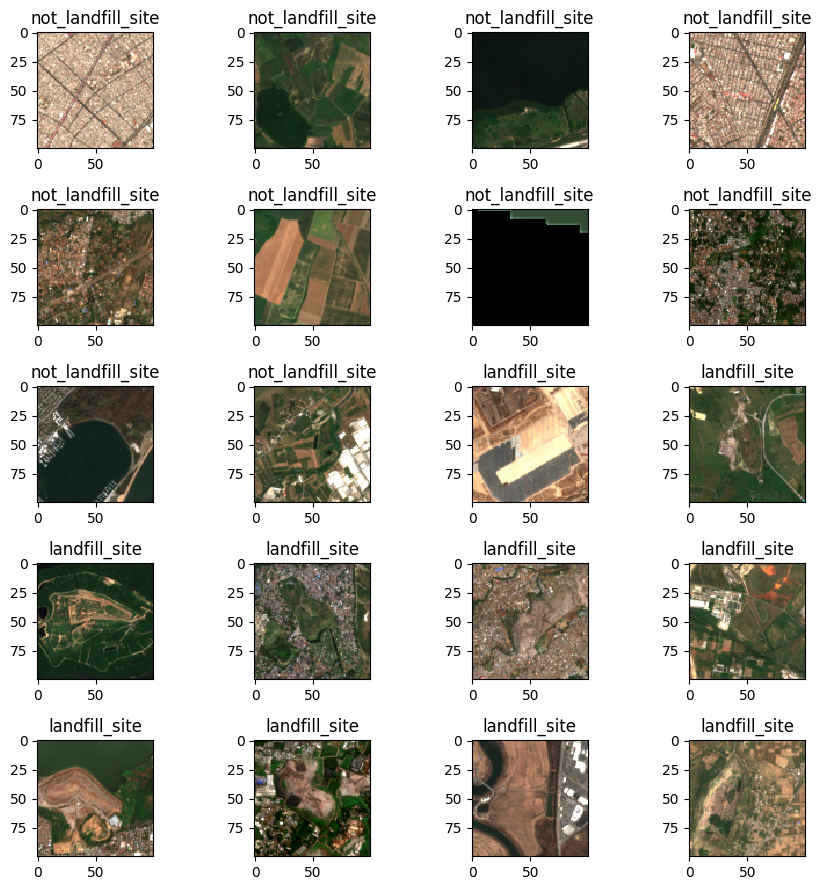

In [10]:
# change the default figure size for all plots created in the program
plt.rcParams['figure.figsize'] = (9,9)

labels =  ['not_landfill_site' , 'landfill_site']

for i in range(20):
    # plt.subplot() function takes three integer arguments: the number of rows, the number of columns, and the index of the subplot.
    plt.subplot(5,4,i+1)
    # plt.imshow() function displays the image at index i in the X_train array as a grayscale image, with no interpolation applied.
    plt.imshow(X_train[i], interpolation='none')
    plt.title("{}".format(labels[int(Y_train[i])]))

plt.tight_layout()

## **Modelling**

In [11]:
img_rows, img_cols = 100, 100
channels = 3

In [12]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

### **Deep learning Model - 01**

In [13]:
def model_1():
    model = Sequential()
    model.add(Flatten(input_shape=(img_rows, img_cols, channels)))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    return model

- The model is constructed using a linear stack of layers.
- The model consists of the following layers:
  - **Flatten Layer:**
    - Converts multi-dimensional input data (an image) into a one-dimensional array.

  - **Dense Layer (with ReLU activation):**
    - Fully connected layer with 128 neurons.
    - Activation function: Rectified Linear Unit (ReLU).

  - **Dense Layer (with Softmax activation):**
    - Final layer with 2 neurons, representing the classes in a binary-class classification task.
    - Activation function: Softmax, producing a probability distribution over the classes.


### **Deep learning Model - 02**

In [14]:
def model_2():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(img_rows, img_cols, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    return model

- The model architecture is designed for image data and includes several convolutional and dense layers.
- The model comprises the following layers:

  - **Convolutional Layer (Conv2D):**
    - Applies 32 filters of size (3, 3) to the input image.
    - Activation function: Rectified Linear Unit (ReLU).

  - **MaxPooling Layer (MaxPooling2D):**
    - Performs max pooling with a pool size of (2, 2), reducing spatial dimensions.
    
  - **Flatten Layer:**
    - Converts the 2D output from the previous layers into a 1D array.
    
  - **Dense Layer (with ReLU activation):**
    - Fully connected layer with 128 neurons.
    - Activation function: Rectified Linear Unit (ReLU).
    
  - **Dense Layer (with Softmax activation):**
    - Final layer with 2 neurons, representing classes in a binary-class classification task.
    - Activation function: Softmax, producing a probability distribution over the classes.

### **Model Execution - Model 01**

In [15]:
model = model_1()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 128)               3840128   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 3840386 (14.65 MB)
Trainable params: 3840386 (14.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
y_train = to_categorical(Y_train, 2)
y_test = to_categorical(Y_test, 2)

Model Building

In [17]:
model.compile(loss=categorical_crossentropy,
              optimizer=RMSprop(learning_rate=0.001),
              metrics='accuracy')

hist = model.fit(X_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=2,
      validation_data=(X_test, y_test),
      validation_split=0.2)

Epoch 1/100
1/1 - 1s - loss: 0.7657 - accuracy: 0.4500 - val_loss: 63.3932 - val_accuracy: 0.5000 - 870ms/epoch - 870ms/step
Epoch 2/100
1/1 - 0s - loss: 84.4466 - accuracy: 0.5000 - val_loss: 1.5266 - val_accuracy: 0.5000 - 131ms/epoch - 131ms/step
Epoch 3/100
1/1 - 0s - loss: 1.6309 - accuracy: 0.5500 - val_loss: 9.7034 - val_accuracy: 0.5000 - 75ms/epoch - 75ms/step
Epoch 4/100
1/1 - 0s - loss: 7.4021 - accuracy: 0.5000 - val_loss: 4.4091 - val_accuracy: 0.5000 - 60ms/epoch - 60ms/step
Epoch 5/100
1/1 - 0s - loss: 3.3279 - accuracy: 0.5000 - val_loss: 0.6552 - val_accuracy: 0.5000 - 68ms/epoch - 68ms/step
Epoch 6/100
1/1 - 0s - loss: 0.6072 - accuracy: 0.7000 - val_loss: 0.7913 - val_accuracy: 0.5000 - 87ms/epoch - 87ms/step
Epoch 7/100
1/1 - 0s - loss: 0.6200 - accuracy: 0.5500 - val_loss: 1.3548 - val_accuracy: 0.5000 - 140ms/epoch - 140ms/step
Epoch 8/100
1/1 - 0s - loss: 0.9451 - accuracy: 0.5000 - val_loss: 1.9289 - val_accuracy: 0.5000 - 76ms/epoch - 76ms/step
Epoch 9/100
1/1 

Evaluate the model

In [18]:
# Evaluate on training data
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', round(train_score[0], 4))
print('Train accuracy:', round(train_score[1], 4), '\n')

# Evaluate on test data
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', round(test_score[0], 4))
print('Test accuracy:', round(test_score[1], 4))

Train loss: 0.1961
Train accuracy: 0.9 

Test loss: 0.9872
Test accuracy: 0.5


The model's very low training loss of 0.1961 during the training phase shows that its predictions were very close to the actual target values in the training dataset. The model appears to have successfully learned the patterns and relationships present in the training dataset based on the high accuracy (90%) on the training data.

The trained model's performance was less impressive when it was tested on a different dataset (the testing dataset). The actual target values in the testing dataset were significantly different from the model's predictions, as evidenced by the testing loss, which was little bit higher at 0.9872. The test accuracy, which gauges the percentage of instances in the testing dataset that were correctly predicted, was 50%.


Plot history of learning

In [19]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]

    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]

    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()

    return

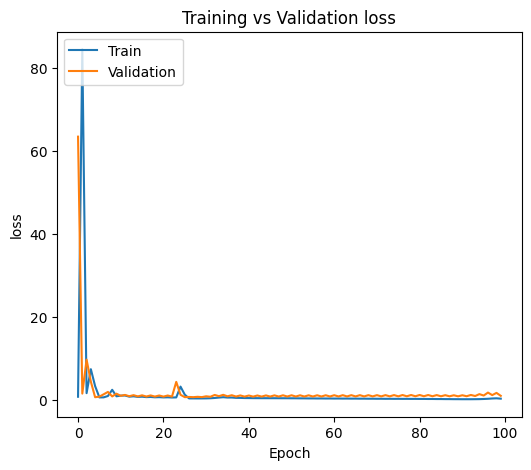

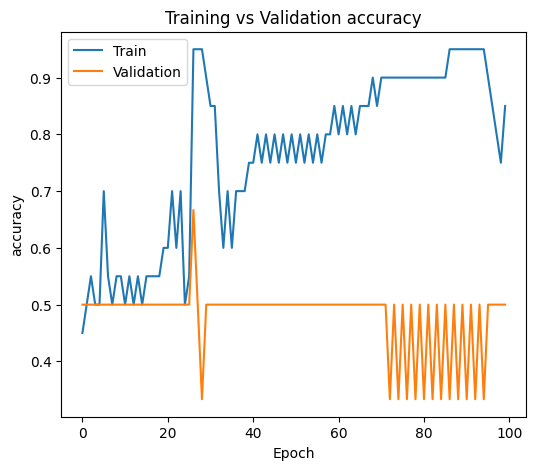

In [20]:
plot_hist(pd.DataFrame(hist.history))

The two plots shown above make it clear that this data works well for training data while the model does function the same way for validation data as well.


Classification Report

In [21]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels to continuous-multioutput format
y_pred_continuous = np.round(y_pred)

# Convert the predicted labels to multiclass format
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test_multiclass, y_pred_multiclass)
print("The result of Kappa is :", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test_multiclass, y_pred_multiclass, target_names= labels)

# Print the report
print("The result of the classification report is: \n ",report)

1/1 [==============================] - 0s 194ms/step
The result of Kappa is : 0.0
The result of the classification report is: 
                     precision    recall  f1-score   support

not_landfill_site       0.00      0.00      0.00         3
    landfill_site       0.50      1.00      0.67         3

         accuracy                           0.50         6
        macro avg       0.25      0.50      0.33         6
     weighted avg       0.25      0.50      0.33         6



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

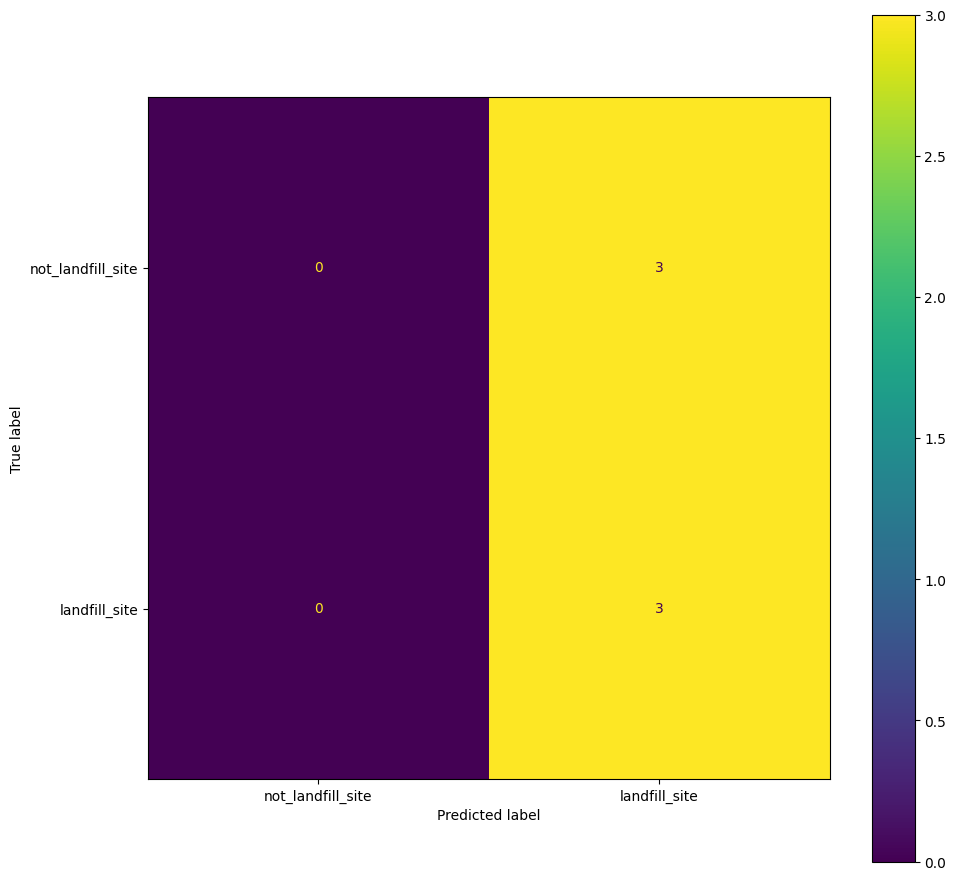

In [22]:
cm = confusion_matrix(
    y_test_multiclass,
    y_pred_multiclass)

# Create a ConfusionMatrixDisplay object
display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels)

# Create a figure with a larger size
fig = plt.figure(figsize=(11, 11))

# Create a subplot within the figure
ax = fig.subplots()

# Plot the confusion matrix as a heatmap
display.plot(ax=ax)

# Show the plot
plt.show()

### **Predictions from Model - 01**

In [23]:
def plot_images(ims, figsize=(12,12), cols=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims = ims[:,:,:,0]
    f = plt.figure(figsize=figsize)
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

1/1 [==============================] - 0s 26ms/step


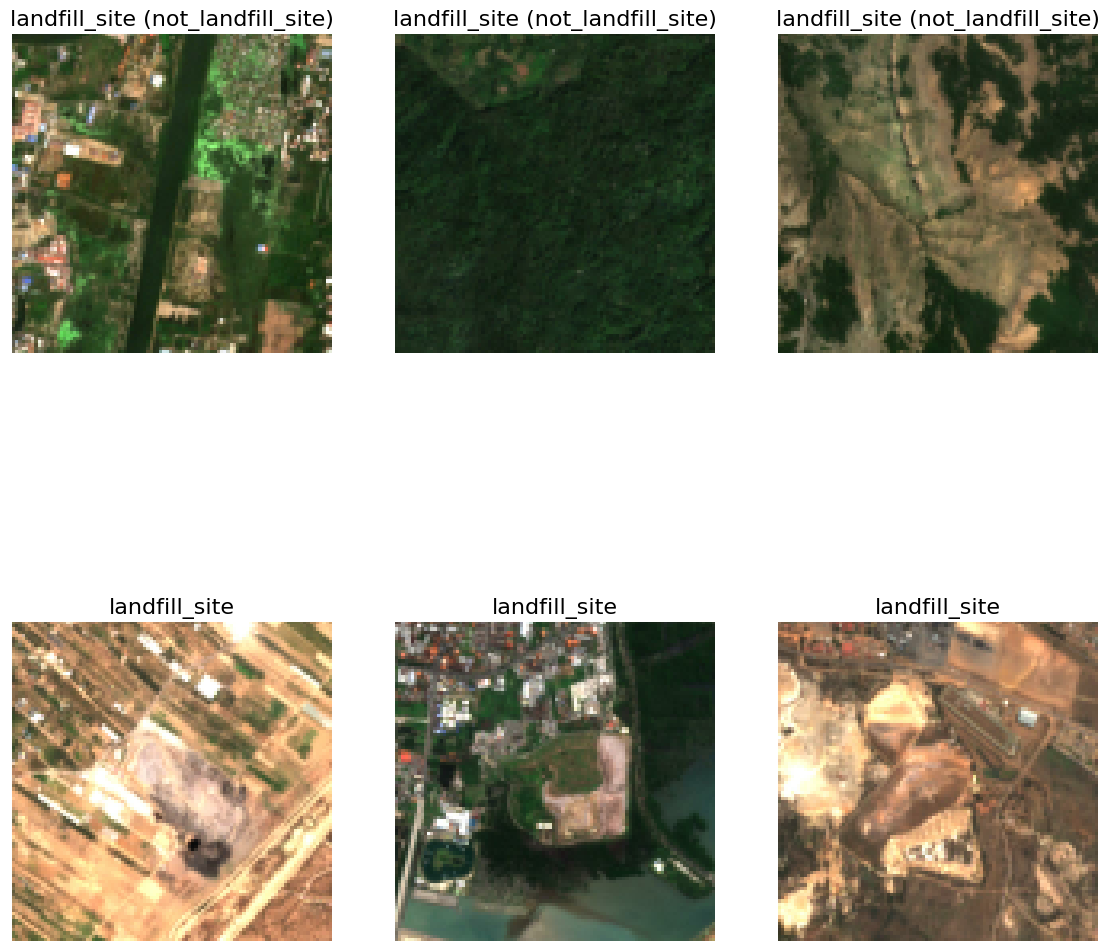

In [24]:
img_range = range(6)
imgs = X_test[img_range]
true_labels = [labels[np.argmax(x)] for x in y_test[img_range]]
predictions = model.predict(imgs.reshape(len(img_range), img_rows, img_cols, channels))
pred_labels = [labels[np.argmax(x)] for x in predictions]
titles = [pred_labels[x]+('' if true_labels[x] == pred_labels[x] else ' ('+true_labels[x]+')') for x in img_range]
plot_images(imgs, cols=3, figsize=(14,14), titles=titles)

### **Model Execution - Model 02**

In [25]:
model = model_2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 76832)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               9834624   
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 9835778 (37.52 MB)
Trainable params: 9835778 (37.52 MB)
Non-trainable params: 0 (0.00 Byte)
______________

In [26]:
y_train = to_categorical(Y_train, 2)
y_test = to_categorical(Y_test, 2)

Model Building

In [27]:
model.compile(loss=categorical_crossentropy,
              optimizer=RMSprop(learning_rate=0.0001),
              metrics='accuracy')

hist = model.fit(X_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=2,
      validation_data=(X_test, y_test),
      validation_split=0.2)

Epoch 1/100
1/1 - 1s - loss: 0.7038 - accuracy: 0.5000 - val_loss: 1.0987 - val_accuracy: 0.5000 - 1s/epoch - 1s/step
Epoch 2/100
1/1 - 0s - loss: 1.0775 - accuracy: 0.5000 - val_loss: 4.6137 - val_accuracy: 0.5000 - 337ms/epoch - 337ms/step
Epoch 3/100
1/1 - 0s - loss: 3.4310 - accuracy: 0.5000 - val_loss: 0.7781 - val_accuracy: 0.5000 - 291ms/epoch - 291ms/step
Epoch 4/100
1/1 - 0s - loss: 0.6172 - accuracy: 0.6000 - val_loss: 0.7020 - val_accuracy: 0.5000 - 303ms/epoch - 303ms/step
Epoch 5/100
1/1 - 0s - loss: 0.6581 - accuracy: 0.6000 - val_loss: 1.1606 - val_accuracy: 0.5000 - 295ms/epoch - 295ms/step
Epoch 6/100
1/1 - 0s - loss: 0.8154 - accuracy: 0.5000 - val_loss: 0.7951 - val_accuracy: 0.5000 - 295ms/epoch - 295ms/step
Epoch 7/100
1/1 - 0s - loss: 0.7941 - accuracy: 0.5500 - val_loss: 0.9417 - val_accuracy: 0.5000 - 342ms/epoch - 342ms/step
Epoch 8/100
1/1 - 0s - loss: 0.6149 - accuracy: 0.6000 - val_loss: 0.7161 - val_accuracy: 0.5000 - 306ms/epoch - 306ms/step
Epoch 9/100
1/

Evaluate the model

In [28]:
# Evaluate on training data
train_score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', round(train_score[0], 4))
print('Train accuracy:', round(train_score[1], 4), '\n')

# Evaluate on test data
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', round(test_score[0], 4))
print('Test accuracy:', round(test_score[1], 4))

Train loss: 0.0448
Train accuracy: 1.0 

Test loss: 0.6175
Test accuracy: 0.8333


The model's very low training loss of 0.0448 during the training phase shows that its predictions were very close to the actual target values in the training dataset. The model appears to have successfully learned the patterns and relationships present in the training dataset based on the high accuracy (100%) on the training data.

The trained model's performance was impressive when it was tested on a different dataset (the testing dataset). The actual target values in the testing dataset were significantly different from the model's predictions, as evidenced by the testing loss, which was not too muuch bad at 0.6175. The test accuracy, which gauges the percentage of instances in the testing dataset that were correctly predicted, was 0.8333 percent, or roughly 83.33%.

Plot history of learning

In [29]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]

    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]

    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()

    return

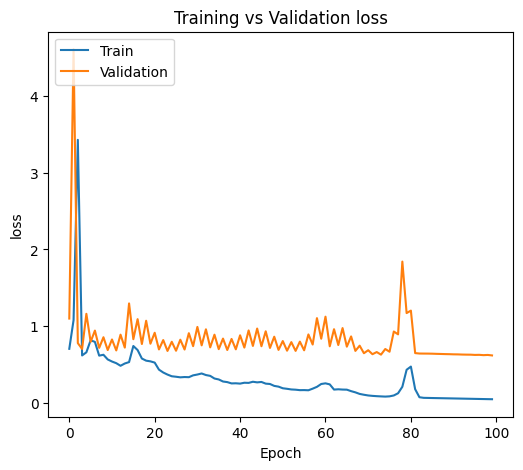

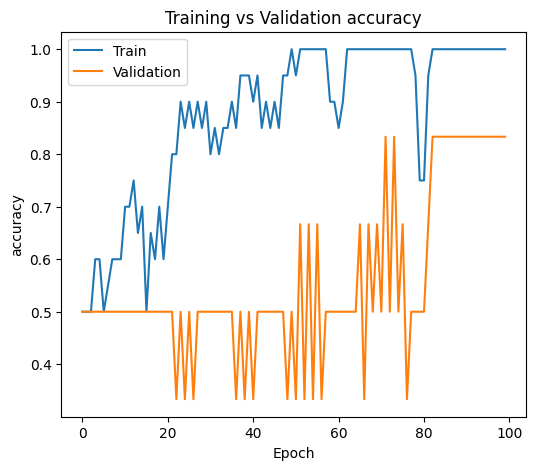

In [30]:
plot_hist(pd.DataFrame(hist.history))

The two plots shown above make it clear that this data works well for training data while the model does not function the same way for validation data.


Classification Report

In [31]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels to continuous-multioutput format
y_pred_continuous = np.round(y_pred)

# Convert the predicted labels to multiclass format
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test_multiclass, y_pred_multiclass)
print("The result of Kappa is :", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test_multiclass, y_pred_multiclass, target_names= labels)

# Print the report
print("The result of the classification report is: \n ",report)

1/1 [==============================] - 0s 83ms/step
The result of Kappa is : 0.667
The result of the classification report is: 
                     precision    recall  f1-score   support

not_landfill_site       1.00      0.67      0.80         3
    landfill_site       0.75      1.00      0.86         3

         accuracy                           0.83         6
        macro avg       0.88      0.83      0.83         6
     weighted avg       0.88      0.83      0.83         6



Confusion Matrix

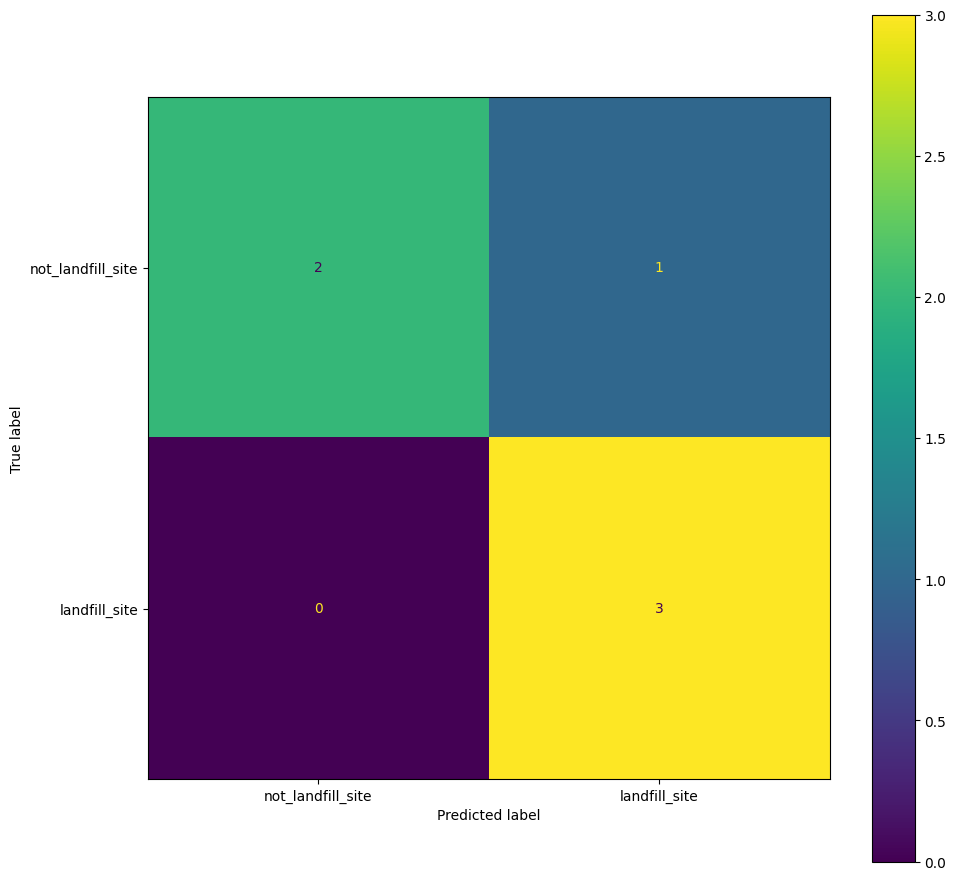

In [32]:
cm = confusion_matrix(
    y_test_multiclass,
    y_pred_multiclass)

# Create a ConfusionMatrixDisplay object
display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels)

# Create a figure with a larger size
fig = plt.figure(figsize=(11, 11))

# Create a subplot within the figure
ax = fig.subplots()

# Plot the confusion matrix as a heatmap
display.plot(ax=ax)

# Show the plot
plt.show()

### **Predictions from Model - 02**

In [33]:
def plot_images(ims, figsize=(12,12), cols=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims = ims[:,:,:,0]
    f = plt.figure(figsize=figsize)
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

1/1 [==============================] - 0s 31ms/step


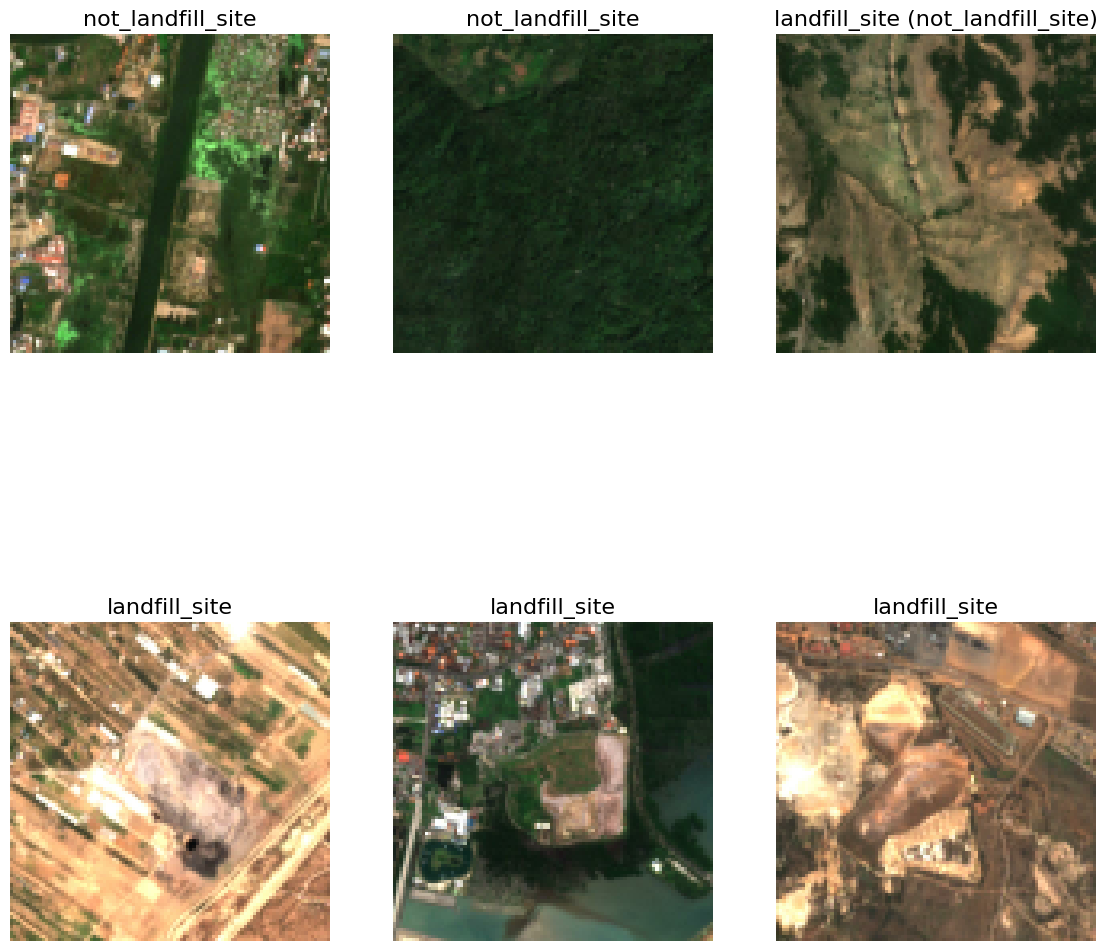

In [34]:
img_range = range(6)
imgs = X_test[img_range]
true_labels = [labels[np.argmax(x)] for x in y_test[img_range]]
predictions = model.predict(imgs.reshape(len(img_range), img_rows, img_cols, channels))
pred_labels = [labels[np.argmax(x)] for x in predictions]
titles = [pred_labels[x]+('' if true_labels[x] == pred_labels[x] else ' ('+true_labels[x]+')') for x in img_range]
plot_images(imgs, cols=3, figsize=(14,14), titles=titles)

### **Model Comparison**



*   Deep learning model 02 works better than the depp learning model 01



### **Potential approaches to improve performance of the pest recognition models for real world deployment in agricultural settings**



*   gather more data (More images)
*   try to get more clearer images

*   improve the pixel size of the images
*   devolop new deep learning architecture to detetct pest with greater accuracy

*   devolop deep learning models with hyper parameter tuning
*   contionoues validation







### **Save the best Model**

In [35]:
model.save('/content/drive/MyDrive/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Pipeline**

In [36]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [ [ 115.213391581353051, -8.728543382473784 ], [ 115.227039223122944, -8.728543382473784 ], [ 115.227039223122944, -8.715053558385005 ], [ 115.213391581353051, -8.715053558385005 ], [ 115.213391581353051, -8.728543382473784 ] ] ,
        ],
}

In [37]:
def pipeline(loaded_model):

  catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace,)
  ## Get the image from the API
  time_of_interest = "2022-01-01/2022-12-30"
  search = catalog.search(collections=["sentinel-2-l2a"],intersects=area_of_interest,datetime=time_of_interest,query={"eo:cloud_cover": {"lt": 10}},)
  items = search.item_collection()
  least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)
  asset_href = least_cloudy_item.assets["visual"].href
  with rasterio.open(asset_href) as ds:
    aoi_bounds = features.bounds(area_of_interest)
    warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
    aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
    band_data = ds.read(window=aoi_window)

  img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
  w = img.size[0]
  h = img.size[1]
  aspect = w / h
  target_w = 800
  target_h = int(target_w / aspect)
  img = img.resize((target_w, target_h), Image.BILINEAR)

  ## Preprocessing the image
  data_test = []
  img = np.array(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, (100, 100))
  data_test.append((img))
  data_test = np.array(data_test)

  ## Predictions
  imgs = data_test
  predictions = loaded_model.predict(imgs.reshape(len(imgs), img_rows, img_cols, channels))
  pred_labels = [labels[np.argmax(x)] for x in predictions]
  titles = [pred_labels]
  plot_images(imgs, cols=3, figsize=(14,14), titles=titles)

  return pred_labels

In [38]:
# Load the saved model from Google Drive
loaded_model = load_model('/content/drive/MyDrive/best_model.h5')

1/1 [==============================] - 0s 46ms/step


['landfill_site']

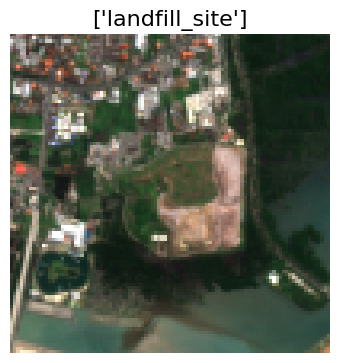

In [39]:
pipeline(loaded_model)